<a href="https://colab.research.google.com/github/BeverlyHuang/hiring_opportunity_prediction/blob/master/Hiring_Opportunity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximizing the Opportunity to be Hired

### Business Understanding
As a marketplace connecting freelance labor with local demand, the company is not only building a digital supply chain network, but also creating a reliable ecosystem in your local community. Thus, to increase the supply chain sustainability, we need to increase the success in the matching process - allowing consumers to find immediate help and allowing taskers to be selected more frequently.
Currently, whenever a Client searches for Taskers, the customer will be given a recommendation of
up to 15 Taskers from which the Client can choose one to book. In this project, I want to understand what makes a Client choose a tasker, and thus how can a Tasker maximize the opportunity to be hired.

### Data Preparation
The sample dataset contains information about "recommendations". For each recommendation, the position of the Tasker in the recommendation set, the hourly rate for the Tasker when they were shown, the number of Tasks the Tasker had completed in that category, whether the Tasker was hired or not, and the category of work the Client needs help with are collected.
Since every recommendation has 1 “hired” and 14 “not hired”, the dataset is highly imbalanced. This will cause bias in the classification model. To solve this problem, I oversampled the minority class by duplicating “hired” entries 14 times.


## Import Packages

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

from tpot import TPOTClassifier

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [0]:
data = pd.read_csv("sample.csv")
data.head()

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly


In [0]:
hired = data[data['hired']==1]
hired.head()

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
12,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009856900,13,50,914,1,Furniture Assembly
24,0-0-cdb916a3-2b2d-4e46-941b-3146c0b12132,2017-09-01 00:32:35,1009856900,10,50,914,1,Furniture Assembly
32,0-0-653cb826-b672-4ddb-92a5-c0e77402a320,2017-09-01 00:33:14,1011985968,3,32,0,1,Moving Help
48,0-0-0cad007f-10da-4ea6-aca1-5eb48e656db3,2017-09-01 00:58:50,1009114267,4,95,1053,1,Moving Help
81,0-0-e930ff65-388e-4802-87d1-a3c7f316935e,2017-09-01 01:14:53,1009072269,11,35,59,1,Furniture Assembly


In [0]:
data = data.append([hired]*14,ignore_index=True)
data.describe()

,tasker_id,position,hourly_rate,num_completed_tasks,hired
count,5.387000e+04,53870.000000,53870.000000,53870.000000,53870.000000
mean,1.011110e+09,6.208131,54.440913,242.359699,0.474754
std,2.455992e+06,4.464780,31.000554,286.389599,0.499367
min,1.006647e+09,1.000000,18.000000,0.000000,0.000000
25%,1.009063e+09,2.000000,38.000000,32.000000,0.000000
50%,1.010579e+09,5.000000,45.000000,135.000000,0.000000
75%,1.013444e+09,10.000000,60.000000,334.000000,1.000000
max,1.015020e+09,15.000000,290.000000,1406.000000,1.000000


## Data Exploration: Overall

After preparing the data, I first looked at the overall correlation between variables using a correlation heat map. From the heat map, we can see that whether the Tasker was hired was negatively correlated with position and hourly rate, and positively correlated with the number of tasks completed. These relationships are more clearly shown in the three bar plots below.

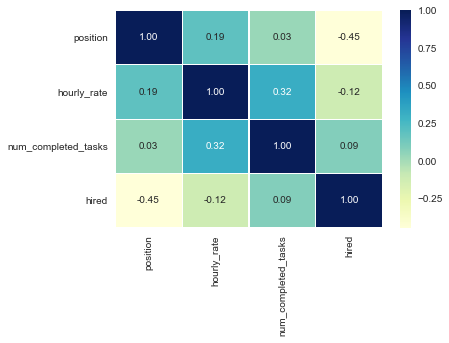

In [0]:
corr = data[['position','hourly_rate','num_completed_tasks','hired']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True, linewidths=0.05, fmt= '.2f', cmap='YlGnBu')

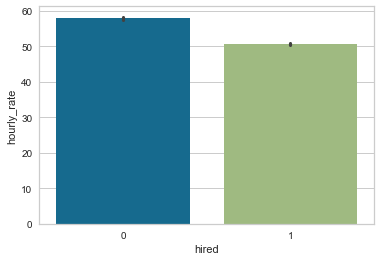

In [0]:
sns.barplot(x="hired", y="hourly_rate", data=data)

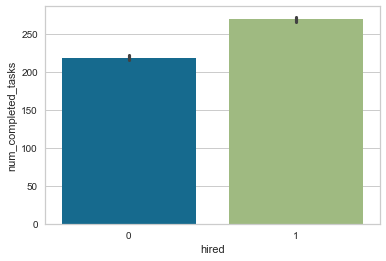

In [0]:
sns.barplot(x="hired", y="num_completed_tasks", data=data)

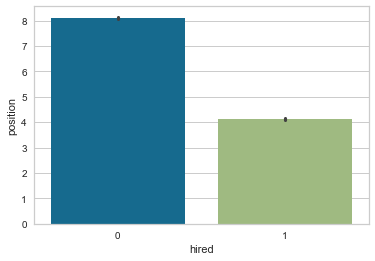

In [0]:
sns.barplot(x="hired", y="position", data=data)

## Explore Three Categories

There are three categories of work in the dataset. For each category, the ranges of hourly rate and number of Tasks completed varied. Thus, to increase the modeling accuracy, I partitioned the dataset on category and performed analysis within each category.

In [0]:
data.category.unique()

array(['Furniture Assembly', 'Moving Help', 'Mounting'], dtype=object)

In [0]:
assembly = data[data["category"]=="Furniture Assembly"]
moving = data[data["category"]=="Moving Help"]
mounting = data[data["category"]=="Mounting"]

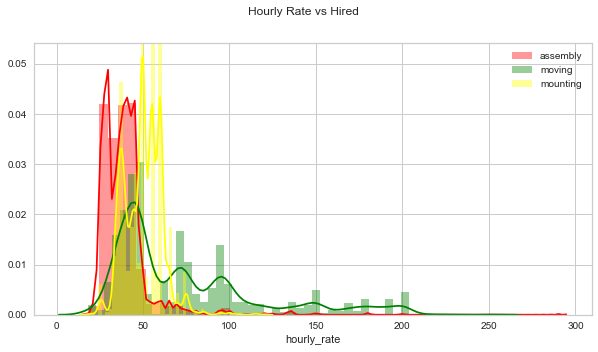

In [0]:
plt.subplots(figsize =(10, 5)) 
sns.distplot(assembly['hourly_rate'] , color='red', label='assembly')
sns.distplot(moving['hourly_rate'] , color='green', label='moving')
sns.distplot(mounting['hourly_rate'] , color='yellow', label='mounting')
plt.suptitle('Hourly Rate vs Hired')
plt.legend()
plt.show()

## Data Exploration: Furniture Assembly Category as an Example

I used “Furniture Assembly” category as an example in this project. A correlation heat map for this category is created which shows similar patterns as the overall data set.
I took out the three features to look at their relationships with “hired or not”. From the three graphs below, we can see that taskers positioned at the top and with lower hourly rate and more tasks completed are more likely to be hired.

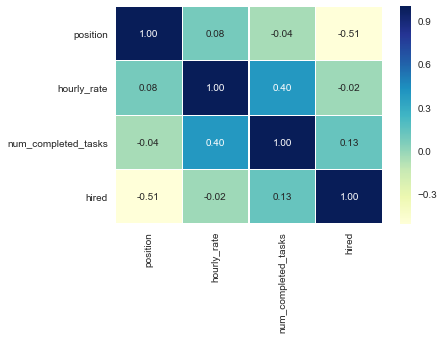

In [0]:
corr = assembly[['position','hourly_rate','num_completed_tasks','hired']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True, linewidths=0.05, fmt= '.2f', cmap='YlGnBu')

In [0]:
hired=data.loc[:,'hired']==1
not_hired=data.loc[:,'hired']==0

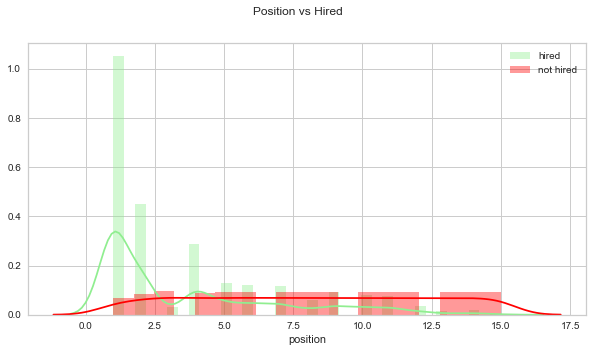

In [0]:
plt.subplots(figsize =(10, 5)) 
sns.distplot(assembly[hired]['position'] , color='lightgreen', label='hired')
sns.distplot(assembly[not_hired]['position'] , color='red', label='not hired')
plt.suptitle('Position vs Hired')
plt.legend()
plt.show()

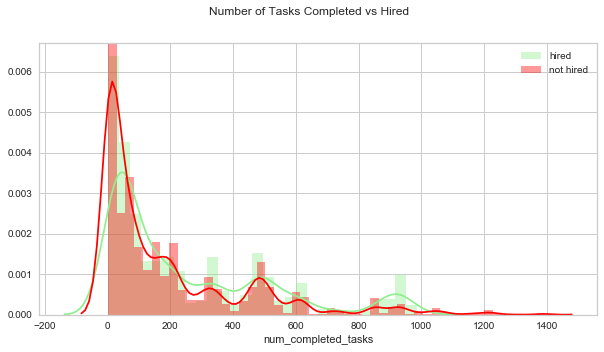

In [0]:
plt.subplots(figsize =(10, 5)) 
sns.distplot(assembly[hired]['num_completed_tasks'] , color='lightgreen', label='hired')
sns.distplot(assembly[not_hired]['num_completed_tasks'] , color='red', label='not hired')
plt.suptitle('Number of Tasks Completed vs Hired')
plt.legend()
plt.show()

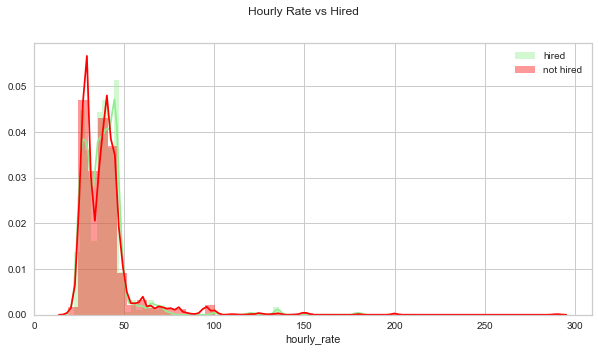

In [0]:
plt.subplots(figsize =(10, 5)) 
sns.distplot(assembly[hired]['hourly_rate'] , color='lightgreen', label='hired')
sns.distplot(assembly[not_hired]['hourly_rate'] , color='red', label='not hired')
plt.suptitle('Hourly Rate vs Hired')
plt.legend()
plt.show()

## Modeling & Evaluation

Three classification models are used in my analysis to capture the relationships between tasker features and hiring decision,

In [0]:
# Seperate features and target
X=assembly[['position','hourly_rate','num_completed_tasks']]
y=assembly['hired']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

## Model 1: Random Forest with GridSearch

I first used Random Forest due to its robustness in handling bias, outliers and unbalanced data. Additionally, I applied GridSearch to find the best combination of parameters for the model, which achieves 0.896 accuracy, 0.89 precision and 0.9 recall on the testing set in predicting “hired”. The classification report, confusion matrix, and ROC curves are shown below.

### Set up hyperparameter grid

In [0]:
param_grid = {'n_estimators': [200,300,400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(3,10),
    'min_samples_leaf': np.arange(2,8),
    'criterion' :['gini', 'entropy']}

### GridSearch for best parameters

In [0]:
rfc=RandomForestClassifier(random_state=1)
rfc_cv = RandomizedSearchCV(rfc, param_grid, cv=10)
rfc_cv.fit(X_train, y_train)
rfc_cv.best_params_

{'n_estimators': 400,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'entropy'}

### Use the best parameters to predict

In [0]:
rfc_cv.score(X_test,y_test)

0.8961687951138256

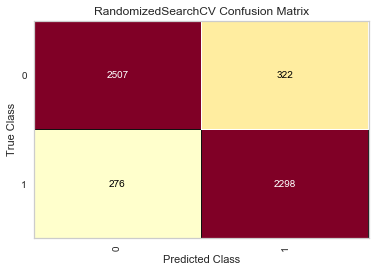

In [0]:
cm = ConfusionMatrix(rfc_cv, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [0]:
y_pred = rfc_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2829
           1       0.89      0.90      0.89      2574

    accuracy                           0.90      5403
   macro avg       0.90      0.90      0.90      5403
weighted avg       0.90      0.90      0.90      5403



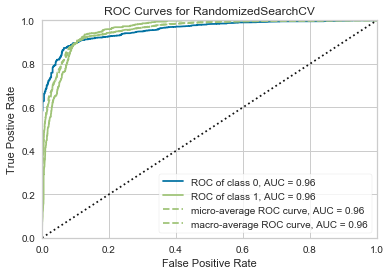

In [0]:
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(rfc_cv)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [0]:
best_rfc = RandomForestClassifier(criterion='entropy', max_depth=9, max_features='auto', min_samples_leaf=2, n_estimators=400, random_state=1)
best_rfc = best_rfc.fit(X_train,y_train)
list(zip(X,best_rfc.feature_importances_))

[('position', 0.5078958881599928),
 ('hourly_rate', 0.17687870115228096),
 ('num_completed_tasks', 0.3152254106877262)]

## Model 2: Auto ML with TPOT

I then used Auto ML due to its power in feature engineering, model selection, and parameter optimization. This model achieves 0.969 accuracy, 0.94 precision and 1 recall on the testing set in predicting “hired”.

In [0]:
tpot = TPOTClassifier(generations=10)
tpot.fit(X_train, y_train)

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=10,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0,
               template='RandomTree', use_dask=False, verbosity=0,
               warm_start=False)

In [0]:
tpot.score(X_test,y_test)

0.9690912456042939

In [0]:
y_pred = tpot.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2829
           1       0.94      1.00      0.97      2574

    accuracy                           0.97      5403
   macro avg       0.97      0.97      0.97      5403
weighted avg       0.97      0.97      0.97      5403



## Model 3: Neural Network

Both Random Forest and Auto ML model have high accuracy in predicting hiring decision in this sample data (30,000 data points). However, as the data size and complexity increases, these two models will not have enough computational power to work on big data. In this case, a neural network model will be a great choice.
Using this data set, I built a neural network model. Since the sample data set is relatively small and clean, setting more layers or nodes might cause overfitting. Thus, I specified only two layers and 50 nodes in each layer. As more and more tasker features collected, we need to tune the parameters accordingly to increase the prediction power.
Another reason to use neural network is that it not only can predict whether the tasker will be hired, but also can estimate their probability of being hired. As shown in the table below, we can see that for tasker hired, the predicted probability is very high (0.98). For those not hired, we can also see their probability to be hired.

In [0]:
# Specify input
n_cols = X_train.shape[1]
input_shape = (n_cols,)
target = to_categorical(y_train)

# Specify the model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape = input_shape))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model.fit(X_train, target, epochs=10, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 8823 samples, validate on 3782 samples
Epoch 1/10
8823/8823 [==============================] - 2s 200us/step - loss: 0.9627 - acc: 0.6876 - val_loss: 0.5447 - val_acc: 0.7499
Epoch 2/10
8823/8823 [==============================] - 1s 77us/step - loss: 0.7193 - acc: 0.7144 - val_loss: 0.5353 - val_acc: 0.7485
Epoch 3/10
8823/8823 [==============================] - 1s 73us/step - loss: 0.7053 - acc: 0.7159 - val_loss: 0.5320 - val_acc: 0.7641
Epoch 4/10
8823/8823 [==============================] - 1s 71us/step - loss: 0.7431 - acc: 0.7174 - val_loss: 0.5349 - val_acc: 0.7565
Epoch 5/10
8823/8823 [==============================] - 1s 71us/step - loss: 0.6077 - acc: 0.7303 - val_loss: 0.6134 - val_acc: 0.7282


In [0]:
predictions = model.predict(X_test)
predictions[:,1]

array([0.49927694, 0.19984333, 0.9849791 , ..., 0.14309968, 0.9301497 ,
       0.06184568], dtype=float32)

In [0]:
proba_hired = pd.concat([X_test, y_test], axis=1)
proba_hired["probability_hired"] = predictions[:,1]
proba_hired.head()

,position,hourly_rate,num_completed_tasks,hired,probability_hired
14456,4,35,27,0,0.499277
4346,14,40,465,0,0.199843
39490,4,40,925,1,0.984979
17129,12,43,526,0,0.426887
4452,15,27,0,0,0.056335


## Model Deployment: Conclusion for Management
This project uses furniture assembly category as an example to understand what makes a Client choose a tasker, and thus how can a Tasker maximize the opportunity to be hired. The same method can be applied to the other two categories.
From both correlation heat map and feature importance, I found that position is the most important feature in determining the hiring decision. Hourly rate and Number of Tasks Completed are also correlated with the hiring decision.
Using the Random Forest and Auto ML model, we can accurately predict whether the tasker would be
  hired. Combining with Neural Network model, we can even calculate the probability of being hired of each tasker. This model can be used to suggest taskers on hourly rate. the company can even launch an intelligent recommendation tool based on this model to suggest hourly rate for each tasker.
Finally, for position, this is out of the tasker’s control. However, it can be a leverage for the company. the company can create tier program to segment taskers and launch a new campaign based on that.
